In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import ladyns as ldn

In [5]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [6]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [7]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [8]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 10

In [9]:
POI[:int(np.sum(~POI) + np.sum(data_r.lockdown[POI]==0)/2)] = False
POI[int(POI.shape[0] - np.sum(data_r.lockdown[POI]==1)/2):] = False

In [10]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [11]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

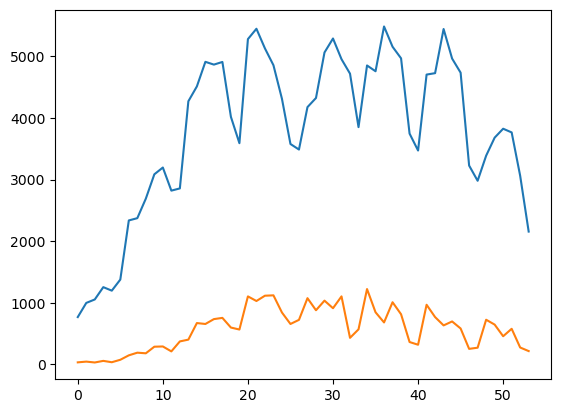

In [12]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [13]:
GPi = np.load('EuropeCovid2_GPi.npz')

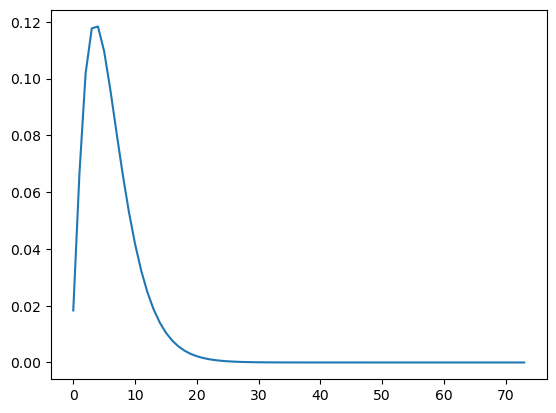

In [14]:
# g
g = np.zeros(T+T0)
g[:np.minimum(T+T0, GPi['g'].shape[0])] = GPi['g'][:np.minimum(T+T0, GPi['g'].shape[0])]
plt.plot(g)

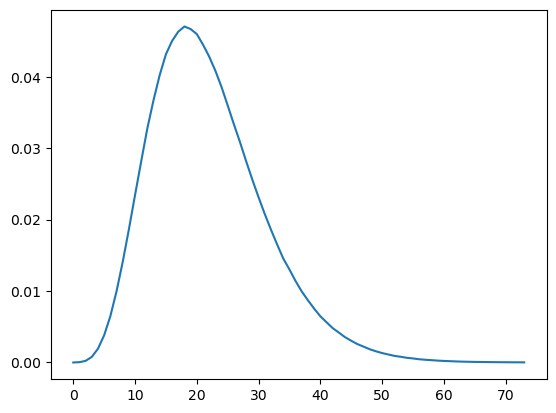

In [15]:
# pi
pi = np.zeros(T+T0)
pi[:np.minimum(T+T0, GPi['g'].shape[0])] = GPi['pi'][:np.minimum(T+T0, GPi['g'].shape[0])]
plt.plot(pi)

In [16]:
# A
d=2
A = np.zeros([T+T0, d])

In [17]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

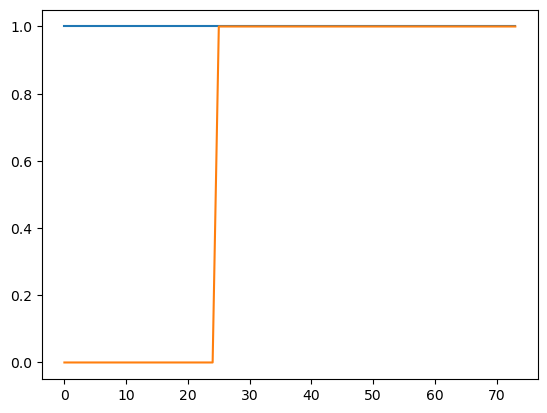

In [18]:
plt.plot(A)

# 3. fit by EM algorithm

In [19]:
def fit(obs, minit_0, sinit_eps, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    mhat_0=minit_0
    shat_eps = sinit_eps
    bhat=binit
    ss=np.inf
    
    # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
    
    if history:
        mhs_0 = np.zeros(n_iter)
        shs_eps = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
    if verbose:
        print("Before EM, shat_eps: %f"%shat_eps)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # iteration for mu
        mhat_0 = (obs @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2)
        # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
        
        # iteration for beta
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        EY = mhat_0 * Pi_inv_ImG[:,0]
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        d1f = - (2/(T+T0)/shat_eps**2) * d1EY @ (obs - EY)
        d2f = (2/(T+T0)/shat_eps**2) * (d1EY @ d1EY.T - d2EY @ (obs-EY))
        
        u, v = la.eig(d2f)
        db = np.real(((v/np.maximum(u,np.max(u)/100)) @ v.T) @ d1f)
        ss = np.min([ss, step_size/np.sqrt(np.sum(db**2))])
        bhat = bhat - ss * db
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
        if history:
            mhs_0[i] = mhat_0
            shs_eps[i] = shat_eps
            bhs[i] = bhat
        
        if verbose:
            print("%d-th iteration finished, shat_eps: %f, lapse: %.3fsec."
                  %(i+1, shat_eps, time.time()-start_iter))
            
    if history:
        return mhs_0, shs_eps, bhs
    else:
        return mhat_0, shat_eps, bhat

In [20]:
mmle_0 = 17.4
smle_eps = 138.5
bmle = [0.207, 1.872]

In [21]:
mhs_0, shs_eps, bhs =\
    fit(Y_data, mmle_0, smle_eps, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=0.05)

Before EM, shat_eps: 603.341411
1-th iteration finished, shat_eps: 179.454190, lapse: 0.035sec.
2-th iteration finished, shat_eps: 179.404515, lapse: 0.002sec.
3-th iteration finished, shat_eps: 179.402621, lapse: 0.009sec.
4-th iteration finished, shat_eps: 179.401998, lapse: 0.004sec.
5-th iteration finished, shat_eps: 179.401406, lapse: 0.002sec.
6-th iteration finished, shat_eps: 179.400816, lapse: 0.002sec.
7-th iteration finished, shat_eps: 179.400229, lapse: 0.003sec.
8-th iteration finished, shat_eps: 179.399644, lapse: 0.001sec.
9-th iteration finished, shat_eps: 179.399061, lapse: 0.001sec.
10-th iteration finished, shat_eps: 179.398481, lapse: 0.001sec.
11-th iteration finished, shat_eps: 179.397902, lapse: 0.001sec.
12-th iteration finished, shat_eps: 179.397326, lapse: 0.001sec.
13-th iteration finished, shat_eps: 179.396752, lapse: 0.001sec.
14-th iteration finished, shat_eps: 179.396180, lapse: 0.001sec.
15-th iteration finished, shat_eps: 179.395610, lapse: 0.002sec.
16

139-th iteration finished, shat_eps: 179.339095, lapse: 0.011sec.
140-th iteration finished, shat_eps: 179.338735, lapse: 0.003sec.
141-th iteration finished, shat_eps: 179.338377, lapse: 0.001sec.
142-th iteration finished, shat_eps: 179.338019, lapse: 0.004sec.
143-th iteration finished, shat_eps: 179.337663, lapse: 0.001sec.
144-th iteration finished, shat_eps: 179.337309, lapse: 0.001sec.
145-th iteration finished, shat_eps: 179.336955, lapse: 0.001sec.
146-th iteration finished, shat_eps: 179.336603, lapse: 0.001sec.
147-th iteration finished, shat_eps: 179.336252, lapse: 0.008sec.
148-th iteration finished, shat_eps: 179.335902, lapse: 0.002sec.
149-th iteration finished, shat_eps: 179.335554, lapse: 0.004sec.
150-th iteration finished, shat_eps: 179.335207, lapse: 0.002sec.
151-th iteration finished, shat_eps: 179.334861, lapse: 0.002sec.
152-th iteration finished, shat_eps: 179.334516, lapse: 0.002sec.
153-th iteration finished, shat_eps: 179.334172, lapse: 0.001sec.
154-th ite

321-th iteration finished, shat_eps: 179.290597, lapse: 0.044sec.
322-th iteration finished, shat_eps: 179.290406, lapse: 0.006sec.
323-th iteration finished, shat_eps: 179.290215, lapse: 0.002sec.
324-th iteration finished, shat_eps: 179.290025, lapse: 0.002sec.
325-th iteration finished, shat_eps: 179.289835, lapse: 0.003sec.
326-th iteration finished, shat_eps: 179.289646, lapse: 0.002sec.
327-th iteration finished, shat_eps: 179.289458, lapse: 0.001sec.
328-th iteration finished, shat_eps: 179.289270, lapse: 0.001sec.
329-th iteration finished, shat_eps: 179.289083, lapse: 0.001sec.
330-th iteration finished, shat_eps: 179.288897, lapse: 0.001sec.
331-th iteration finished, shat_eps: 179.288711, lapse: 0.003sec.
332-th iteration finished, shat_eps: 179.288526, lapse: 0.003sec.
333-th iteration finished, shat_eps: 179.288341, lapse: 0.006sec.
334-th iteration finished, shat_eps: 179.288158, lapse: 0.002sec.
335-th iteration finished, shat_eps: 179.287974, lapse: 0.001sec.
336-th ite

513-th iteration finished, shat_eps: 179.263356, lapse: 0.023sec.
514-th iteration finished, shat_eps: 179.263254, lapse: 0.006sec.
515-th iteration finished, shat_eps: 179.263152, lapse: 0.002sec.
516-th iteration finished, shat_eps: 179.263051, lapse: 0.008sec.
517-th iteration finished, shat_eps: 179.262950, lapse: 0.003sec.
518-th iteration finished, shat_eps: 179.262850, lapse: 0.007sec.
519-th iteration finished, shat_eps: 179.262749, lapse: 0.002sec.
520-th iteration finished, shat_eps: 179.262649, lapse: 0.001sec.
521-th iteration finished, shat_eps: 179.262550, lapse: 0.001sec.
522-th iteration finished, shat_eps: 179.262450, lapse: 0.002sec.
523-th iteration finished, shat_eps: 179.262351, lapse: 0.004sec.
524-th iteration finished, shat_eps: 179.262253, lapse: 0.011sec.
525-th iteration finished, shat_eps: 179.262154, lapse: 0.002sec.
526-th iteration finished, shat_eps: 179.262056, lapse: 0.005sec.
527-th iteration finished, shat_eps: 179.261959, lapse: 0.003sec.
528-th ite

690-th iteration finished, shat_eps: 179.249540, lapse: 0.071sec.
691-th iteration finished, shat_eps: 179.249482, lapse: 0.003sec.
692-th iteration finished, shat_eps: 179.249424, lapse: 0.002sec.
693-th iteration finished, shat_eps: 179.249366, lapse: 0.002sec.
694-th iteration finished, shat_eps: 179.249308, lapse: 0.002sec.
695-th iteration finished, shat_eps: 179.249251, lapse: 0.002sec.
696-th iteration finished, shat_eps: 179.249194, lapse: 0.003sec.
697-th iteration finished, shat_eps: 179.249136, lapse: 0.002sec.
698-th iteration finished, shat_eps: 179.249079, lapse: 0.002sec.
699-th iteration finished, shat_eps: 179.249023, lapse: 0.002sec.
700-th iteration finished, shat_eps: 179.248966, lapse: 0.002sec.
701-th iteration finished, shat_eps: 179.248909, lapse: 0.002sec.
702-th iteration finished, shat_eps: 179.248853, lapse: 0.001sec.
703-th iteration finished, shat_eps: 179.248797, lapse: 0.001sec.
704-th iteration finished, shat_eps: 179.248741, lapse: 0.001sec.
705-th ite

818-th iteration finished, shat_eps: 179.243373, lapse: 0.006sec.
819-th iteration finished, shat_eps: 179.243334, lapse: 0.003sec.
820-th iteration finished, shat_eps: 179.243295, lapse: 0.002sec.
821-th iteration finished, shat_eps: 179.243256, lapse: 0.005sec.
822-th iteration finished, shat_eps: 179.243217, lapse: 0.002sec.
823-th iteration finished, shat_eps: 179.243178, lapse: 0.002sec.
824-th iteration finished, shat_eps: 179.243139, lapse: 0.002sec.
825-th iteration finished, shat_eps: 179.243101, lapse: 0.003sec.
826-th iteration finished, shat_eps: 179.243062, lapse: 0.002sec.
827-th iteration finished, shat_eps: 179.243024, lapse: 0.003sec.
828-th iteration finished, shat_eps: 179.242986, lapse: 0.001sec.
829-th iteration finished, shat_eps: 179.242948, lapse: 0.001sec.
830-th iteration finished, shat_eps: 179.242910, lapse: 0.001sec.
831-th iteration finished, shat_eps: 179.242872, lapse: 0.001sec.
832-th iteration finished, shat_eps: 179.242834, lapse: 0.001sec.
833-th ite

965-th iteration finished, shat_eps: 179.238710, lapse: 0.002sec.
966-th iteration finished, shat_eps: 179.238685, lapse: 0.002sec.
967-th iteration finished, shat_eps: 179.238659, lapse: 0.002sec.
968-th iteration finished, shat_eps: 179.238634, lapse: 0.002sec.
969-th iteration finished, shat_eps: 179.238610, lapse: 0.002sec.
970-th iteration finished, shat_eps: 179.238585, lapse: 0.002sec.
971-th iteration finished, shat_eps: 179.238560, lapse: 0.002sec.
972-th iteration finished, shat_eps: 179.238535, lapse: 0.002sec.
973-th iteration finished, shat_eps: 179.238511, lapse: 0.010sec.
974-th iteration finished, shat_eps: 179.238486, lapse: 0.002sec.
975-th iteration finished, shat_eps: 179.238461, lapse: 0.001sec.
976-th iteration finished, shat_eps: 179.238437, lapse: 0.002sec.
977-th iteration finished, shat_eps: 179.238413, lapse: 0.001sec.
978-th iteration finished, shat_eps: 179.238388, lapse: 0.001sec.
979-th iteration finished, shat_eps: 179.238364, lapse: 0.001sec.
980-th ite

1163-th iteration finished, shat_eps: 179.234941, lapse: 0.007sec.
1164-th iteration finished, shat_eps: 179.234927, lapse: 0.002sec.
1165-th iteration finished, shat_eps: 179.234914, lapse: 0.006sec.
1166-th iteration finished, shat_eps: 179.234900, lapse: 0.002sec.
1167-th iteration finished, shat_eps: 179.234886, lapse: 0.001sec.
1168-th iteration finished, shat_eps: 179.234872, lapse: 0.004sec.
1169-th iteration finished, shat_eps: 179.234858, lapse: 0.001sec.
1170-th iteration finished, shat_eps: 179.234845, lapse: 0.001sec.
1171-th iteration finished, shat_eps: 179.234831, lapse: 0.001sec.
1172-th iteration finished, shat_eps: 179.234817, lapse: 0.003sec.
1173-th iteration finished, shat_eps: 179.234804, lapse: 0.002sec.
1174-th iteration finished, shat_eps: 179.234790, lapse: 0.002sec.
1175-th iteration finished, shat_eps: 179.234776, lapse: 0.001sec.
1176-th iteration finished, shat_eps: 179.234763, lapse: 0.001sec.
1177-th iteration finished, shat_eps: 179.234750, lapse: 0.004

1292-th iteration finished, shat_eps: 179.233440, lapse: 0.001sec.
1293-th iteration finished, shat_eps: 179.233430, lapse: 0.010sec.
1294-th iteration finished, shat_eps: 179.233421, lapse: 0.002sec.
1295-th iteration finished, shat_eps: 179.233411, lapse: 0.001sec.
1296-th iteration finished, shat_eps: 179.233402, lapse: 0.001sec.
1297-th iteration finished, shat_eps: 179.233392, lapse: 0.001sec.
1298-th iteration finished, shat_eps: 179.233383, lapse: 0.001sec.
1299-th iteration finished, shat_eps: 179.233373, lapse: 0.001sec.
1300-th iteration finished, shat_eps: 179.233364, lapse: 0.005sec.
1301-th iteration finished, shat_eps: 179.233355, lapse: 0.001sec.
1302-th iteration finished, shat_eps: 179.233345, lapse: 0.002sec.
1303-th iteration finished, shat_eps: 179.233336, lapse: 0.008sec.
1304-th iteration finished, shat_eps: 179.233327, lapse: 0.002sec.
1305-th iteration finished, shat_eps: 179.233317, lapse: 0.001sec.
1306-th iteration finished, shat_eps: 179.233308, lapse: 0.001

1420-th iteration finished, shat_eps: 179.232416, lapse: 0.003sec.
1421-th iteration finished, shat_eps: 179.232410, lapse: 0.002sec.
1422-th iteration finished, shat_eps: 179.232403, lapse: 0.002sec.
1423-th iteration finished, shat_eps: 179.232396, lapse: 0.002sec.
1424-th iteration finished, shat_eps: 179.232390, lapse: 0.002sec.
1425-th iteration finished, shat_eps: 179.232383, lapse: 0.002sec.
1426-th iteration finished, shat_eps: 179.232377, lapse: 0.002sec.
1427-th iteration finished, shat_eps: 179.232370, lapse: 0.010sec.
1428-th iteration finished, shat_eps: 179.232364, lapse: 0.001sec.
1429-th iteration finished, shat_eps: 179.232358, lapse: 0.001sec.
1430-th iteration finished, shat_eps: 179.232351, lapse: 0.001sec.
1431-th iteration finished, shat_eps: 179.232345, lapse: 0.001sec.
1432-th iteration finished, shat_eps: 179.232338, lapse: 0.001sec.
1433-th iteration finished, shat_eps: 179.232332, lapse: 0.001sec.
1434-th iteration finished, shat_eps: 179.232326, lapse: 0.001

1567-th iteration finished, shat_eps: 179.231626, lapse: 0.003sec.
1568-th iteration finished, shat_eps: 179.231622, lapse: 0.002sec.
1569-th iteration finished, shat_eps: 179.231617, lapse: 0.006sec.
1570-th iteration finished, shat_eps: 179.231613, lapse: 0.003sec.
1571-th iteration finished, shat_eps: 179.231609, lapse: 0.001sec.
1572-th iteration finished, shat_eps: 179.231604, lapse: 0.001sec.
1573-th iteration finished, shat_eps: 179.231600, lapse: 0.001sec.
1574-th iteration finished, shat_eps: 179.231596, lapse: 0.001sec.
1575-th iteration finished, shat_eps: 179.231592, lapse: 0.001sec.
1576-th iteration finished, shat_eps: 179.231587, lapse: 0.002sec.
1577-th iteration finished, shat_eps: 179.231583, lapse: 0.001sec.
1578-th iteration finished, shat_eps: 179.231579, lapse: 0.001sec.
1579-th iteration finished, shat_eps: 179.231575, lapse: 0.005sec.
1580-th iteration finished, shat_eps: 179.231571, lapse: 0.002sec.
1581-th iteration finished, shat_eps: 179.231567, lapse: 0.002

1782-th iteration finished, shat_eps: 179.230933, lapse: 0.005sec.
1783-th iteration finished, shat_eps: 179.230931, lapse: 0.002sec.
1784-th iteration finished, shat_eps: 179.230929, lapse: 0.007sec.
1785-th iteration finished, shat_eps: 179.230926, lapse: 0.003sec.
1786-th iteration finished, shat_eps: 179.230924, lapse: 0.001sec.
1787-th iteration finished, shat_eps: 179.230922, lapse: 0.003sec.
1788-th iteration finished, shat_eps: 179.230920, lapse: 0.002sec.
1789-th iteration finished, shat_eps: 179.230917, lapse: 0.001sec.
1790-th iteration finished, shat_eps: 179.230915, lapse: 0.001sec.
1791-th iteration finished, shat_eps: 179.230913, lapse: 0.001sec.
1792-th iteration finished, shat_eps: 179.230910, lapse: 0.002sec.
1793-th iteration finished, shat_eps: 179.230908, lapse: 0.002sec.
1794-th iteration finished, shat_eps: 179.230906, lapse: 0.001sec.
1795-th iteration finished, shat_eps: 179.230904, lapse: 0.001sec.
1796-th iteration finished, shat_eps: 179.230901, lapse: 0.001

1934-th iteration finished, shat_eps: 179.230646, lapse: 0.002sec.
1935-th iteration finished, shat_eps: 179.230644, lapse: 0.002sec.
1936-th iteration finished, shat_eps: 179.230643, lapse: 0.002sec.
1937-th iteration finished, shat_eps: 179.230641, lapse: 0.002sec.
1938-th iteration finished, shat_eps: 179.230640, lapse: 0.010sec.
1939-th iteration finished, shat_eps: 179.230638, lapse: 0.002sec.
1940-th iteration finished, shat_eps: 179.230637, lapse: 0.002sec.
1941-th iteration finished, shat_eps: 179.230635, lapse: 0.002sec.
1942-th iteration finished, shat_eps: 179.230634, lapse: 0.002sec.
1943-th iteration finished, shat_eps: 179.230632, lapse: 0.003sec.
1944-th iteration finished, shat_eps: 179.230631, lapse: 0.002sec.
1945-th iteration finished, shat_eps: 179.230630, lapse: 0.001sec.
1946-th iteration finished, shat_eps: 179.230628, lapse: 0.001sec.
1947-th iteration finished, shat_eps: 179.230627, lapse: 0.001sec.
1948-th iteration finished, shat_eps: 179.230625, lapse: 0.001

2136-th iteration finished, shat_eps: 179.230414, lapse: 0.002sec.
2137-th iteration finished, shat_eps: 179.230413, lapse: 0.002sec.
2138-th iteration finished, shat_eps: 179.230412, lapse: 0.002sec.
2139-th iteration finished, shat_eps: 179.230411, lapse: 0.002sec.
2140-th iteration finished, shat_eps: 179.230410, lapse: 0.002sec.
2141-th iteration finished, shat_eps: 179.230409, lapse: 0.002sec.
2142-th iteration finished, shat_eps: 179.230409, lapse: 0.003sec.
2143-th iteration finished, shat_eps: 179.230408, lapse: 0.010sec.
2144-th iteration finished, shat_eps: 179.230407, lapse: 0.003sec.
2145-th iteration finished, shat_eps: 179.230406, lapse: 0.002sec.
2146-th iteration finished, shat_eps: 179.230405, lapse: 0.002sec.
2147-th iteration finished, shat_eps: 179.230404, lapse: 0.003sec.
2148-th iteration finished, shat_eps: 179.230404, lapse: 0.001sec.
2149-th iteration finished, shat_eps: 179.230403, lapse: 0.001sec.
2150-th iteration finished, shat_eps: 179.230402, lapse: 0.001

2262-th iteration finished, shat_eps: 179.230323, lapse: 0.002sec.
2263-th iteration finished, shat_eps: 179.230323, lapse: 0.002sec.
2264-th iteration finished, shat_eps: 179.230322, lapse: 0.002sec.
2265-th iteration finished, shat_eps: 179.230322, lapse: 0.002sec.
2266-th iteration finished, shat_eps: 179.230321, lapse: 0.002sec.
2267-th iteration finished, shat_eps: 179.230320, lapse: 0.002sec.
2268-th iteration finished, shat_eps: 179.230320, lapse: 0.002sec.
2269-th iteration finished, shat_eps: 179.230319, lapse: 0.002sec.
2270-th iteration finished, shat_eps: 179.230319, lapse: 0.002sec.
2271-th iteration finished, shat_eps: 179.230318, lapse: 0.002sec.
2272-th iteration finished, shat_eps: 179.230317, lapse: 0.001sec.
2273-th iteration finished, shat_eps: 179.230317, lapse: 0.001sec.
2274-th iteration finished, shat_eps: 179.230316, lapse: 0.004sec.
2275-th iteration finished, shat_eps: 179.230316, lapse: 0.002sec.
2276-th iteration finished, shat_eps: 179.230315, lapse: 0.002

2416-th iteration finished, shat_eps: 179.230249, lapse: 0.001sec.
2417-th iteration finished, shat_eps: 179.230248, lapse: 0.002sec.
2418-th iteration finished, shat_eps: 179.230248, lapse: 0.002sec.
2419-th iteration finished, shat_eps: 179.230248, lapse: 0.002sec.
2420-th iteration finished, shat_eps: 179.230247, lapse: 0.002sec.
2421-th iteration finished, shat_eps: 179.230247, lapse: 0.010sec.
2422-th iteration finished, shat_eps: 179.230246, lapse: 0.002sec.
2423-th iteration finished, shat_eps: 179.230246, lapse: 0.002sec.
2424-th iteration finished, shat_eps: 179.230246, lapse: 0.001sec.
2425-th iteration finished, shat_eps: 179.230245, lapse: 0.001sec.
2426-th iteration finished, shat_eps: 179.230245, lapse: 0.001sec.
2427-th iteration finished, shat_eps: 179.230245, lapse: 0.001sec.
2428-th iteration finished, shat_eps: 179.230244, lapse: 0.001sec.
2429-th iteration finished, shat_eps: 179.230244, lapse: 0.001sec.
2430-th iteration finished, shat_eps: 179.230243, lapse: 0.001

2539-th iteration finished, shat_eps: 179.230209, lapse: 0.002sec.
2540-th iteration finished, shat_eps: 179.230208, lapse: 0.002sec.
2541-th iteration finished, shat_eps: 179.230208, lapse: 0.002sec.
2542-th iteration finished, shat_eps: 179.230208, lapse: 0.003sec.
2543-th iteration finished, shat_eps: 179.230208, lapse: 0.002sec.
2544-th iteration finished, shat_eps: 179.230207, lapse: 0.006sec.
2545-th iteration finished, shat_eps: 179.230207, lapse: 0.003sec.
2546-th iteration finished, shat_eps: 179.230207, lapse: 0.001sec.
2547-th iteration finished, shat_eps: 179.230206, lapse: 0.001sec.
2548-th iteration finished, shat_eps: 179.230206, lapse: 0.001sec.
2549-th iteration finished, shat_eps: 179.230206, lapse: 0.001sec.
2550-th iteration finished, shat_eps: 179.230206, lapse: 0.001sec.
2551-th iteration finished, shat_eps: 179.230205, lapse: 0.001sec.
2552-th iteration finished, shat_eps: 179.230205, lapse: 0.001sec.
2553-th iteration finished, shat_eps: 179.230205, lapse: 0.005

2775-th iteration finished, shat_eps: 179.230161, lapse: 0.002sec.
2776-th iteration finished, shat_eps: 179.230161, lapse: 0.011sec.
2777-th iteration finished, shat_eps: 179.230161, lapse: 0.002sec.
2778-th iteration finished, shat_eps: 179.230161, lapse: 0.001sec.
2779-th iteration finished, shat_eps: 179.230161, lapse: 0.001sec.
2780-th iteration finished, shat_eps: 179.230161, lapse: 0.001sec.
2781-th iteration finished, shat_eps: 179.230161, lapse: 0.001sec.
2782-th iteration finished, shat_eps: 179.230161, lapse: 0.001sec.
2783-th iteration finished, shat_eps: 179.230160, lapse: 0.001sec.
2784-th iteration finished, shat_eps: 179.230160, lapse: 0.002sec.
2785-th iteration finished, shat_eps: 179.230160, lapse: 0.001sec.
2786-th iteration finished, shat_eps: 179.230160, lapse: 0.001sec.
2787-th iteration finished, shat_eps: 179.230160, lapse: 0.002sec.
2788-th iteration finished, shat_eps: 179.230160, lapse: 0.002sec.
2789-th iteration finished, shat_eps: 179.230160, lapse: 0.002

2925-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2926-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2927-th iteration finished, shat_eps: 179.230144, lapse: 0.009sec.
2928-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2929-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2930-th iteration finished, shat_eps: 179.230144, lapse: 0.001sec.
2931-th iteration finished, shat_eps: 179.230144, lapse: 0.001sec.
2932-th iteration finished, shat_eps: 179.230144, lapse: 0.001sec.
2933-th iteration finished, shat_eps: 179.230144, lapse: 0.001sec.
2934-th iteration finished, shat_eps: 179.230143, lapse: 0.001sec.
2935-th iteration finished, shat_eps: 179.230143, lapse: 0.001sec.
2936-th iteration finished, shat_eps: 179.230143, lapse: 0.002sec.
2937-th iteration finished, shat_eps: 179.230143, lapse: 0.001sec.
2938-th iteration finished, shat_eps: 179.230143, lapse: 0.001sec.
2939-th iteration finished, shat_eps: 179.230143, lapse: 0.001

3198-th iteration finished, shat_eps: 179.230127, lapse: 0.001sec.
3199-th iteration finished, shat_eps: 179.230127, lapse: 0.002sec.
3200-th iteration finished, shat_eps: 179.230127, lapse: 0.002sec.
3201-th iteration finished, shat_eps: 179.230127, lapse: 0.002sec.
3202-th iteration finished, shat_eps: 179.230126, lapse: 0.012sec.
3203-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3204-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3205-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3206-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3207-th iteration finished, shat_eps: 179.230126, lapse: 0.004sec.
3208-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3209-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3210-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3211-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3212-th iteration finished, shat_eps: 179.230126, lapse: 0.001

3347-th iteration finished, shat_eps: 179.230121, lapse: 0.002sec.
3348-th iteration finished, shat_eps: 179.230121, lapse: 0.012sec.
3349-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3350-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3351-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3352-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3353-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3354-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3355-th iteration finished, shat_eps: 179.230121, lapse: 0.002sec.
3356-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3357-th iteration finished, shat_eps: 179.230121, lapse: 0.002sec.
3358-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3359-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3360-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3361-th iteration finished, shat_eps: 179.230121, lapse: 0.002

3495-th iteration finished, shat_eps: 179.230118, lapse: 0.020sec.
3496-th iteration finished, shat_eps: 179.230118, lapse: 0.002sec.
3497-th iteration finished, shat_eps: 179.230118, lapse: 0.001sec.
3498-th iteration finished, shat_eps: 179.230118, lapse: 0.002sec.
3499-th iteration finished, shat_eps: 179.230118, lapse: 0.002sec.
3500-th iteration finished, shat_eps: 179.230118, lapse: 0.009sec.
3501-th iteration finished, shat_eps: 179.230118, lapse: 0.002sec.
3502-th iteration finished, shat_eps: 179.230118, lapse: 0.003sec.
3503-th iteration finished, shat_eps: 179.230118, lapse: 0.002sec.
3504-th iteration finished, shat_eps: 179.230118, lapse: 0.001sec.
3505-th iteration finished, shat_eps: 179.230118, lapse: 0.006sec.
3506-th iteration finished, shat_eps: 179.230118, lapse: 0.002sec.
3507-th iteration finished, shat_eps: 179.230118, lapse: 0.002sec.
3508-th iteration finished, shat_eps: 179.230118, lapse: 0.002sec.
3509-th iteration finished, shat_eps: 179.230118, lapse: 0.001

3643-th iteration finished, shat_eps: 179.230116, lapse: 0.003sec.
3644-th iteration finished, shat_eps: 179.230116, lapse: 0.010sec.
3645-th iteration finished, shat_eps: 179.230116, lapse: 0.002sec.
3646-th iteration finished, shat_eps: 179.230116, lapse: 0.002sec.
3647-th iteration finished, shat_eps: 179.230116, lapse: 0.002sec.
3648-th iteration finished, shat_eps: 179.230116, lapse: 0.002sec.
3649-th iteration finished, shat_eps: 179.230116, lapse: 0.003sec.
3650-th iteration finished, shat_eps: 179.230116, lapse: 0.001sec.
3651-th iteration finished, shat_eps: 179.230116, lapse: 0.004sec.
3652-th iteration finished, shat_eps: 179.230116, lapse: 0.002sec.
3653-th iteration finished, shat_eps: 179.230116, lapse: 0.001sec.
3654-th iteration finished, shat_eps: 179.230116, lapse: 0.001sec.
3655-th iteration finished, shat_eps: 179.230116, lapse: 0.003sec.
3656-th iteration finished, shat_eps: 179.230116, lapse: 0.002sec.
3657-th iteration finished, shat_eps: 179.230116, lapse: 0.002

3773-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3774-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3775-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3776-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3777-th iteration finished, shat_eps: 179.230114, lapse: 0.011sec.
3778-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3779-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3780-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3781-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3782-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3783-th iteration finished, shat_eps: 179.230114, lapse: 0.001sec.
3784-th iteration finished, shat_eps: 179.230114, lapse: 0.001sec.
3785-th iteration finished, shat_eps: 179.230114, lapse: 0.001sec.
3786-th iteration finished, shat_eps: 179.230114, lapse: 0.001sec.
3787-th iteration finished, shat_eps: 179.230114, lapse: 0.001

3949-th iteration finished, shat_eps: 179.230113, lapse: 0.003sec.
3950-th iteration finished, shat_eps: 179.230113, lapse: 0.009sec.
3951-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3952-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3953-th iteration finished, shat_eps: 179.230113, lapse: 0.003sec.
3954-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3955-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3956-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3957-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3958-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3959-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3960-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
3961-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
3962-th iteration finished, shat_eps: 179.230113, lapse: 0.003sec.
3963-th iteration finished, shat_eps: 179.230113, lapse: 0.002

4088-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4089-th iteration finished, shat_eps: 179.230113, lapse: 0.010sec.
4090-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
4091-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
4092-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4093-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4094-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4095-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4096-th iteration finished, shat_eps: 179.230113, lapse: 0.003sec.
4097-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4098-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
4099-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
4100-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
4101-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4102-th iteration finished, shat_eps: 179.230112, lapse: 0.003

4234-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4235-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4236-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4237-th iteration finished, shat_eps: 179.230112, lapse: 0.010sec.
4238-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4239-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4240-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4241-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4242-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4243-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4244-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4245-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4246-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4247-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4248-th iteration finished, shat_eps: 179.230112, lapse: 0.002

4367-th iteration finished, shat_eps: 179.230112, lapse: 0.003sec.
4368-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4369-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4370-th iteration finished, shat_eps: 179.230112, lapse: 0.011sec.
4371-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4372-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4373-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4374-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4375-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4376-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4377-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4378-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4379-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4380-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4381-th iteration finished, shat_eps: 179.230112, lapse: 0.001

4518-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4519-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4520-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4521-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4522-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4523-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4524-th iteration finished, shat_eps: 179.230112, lapse: 0.038sec.
4525-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4526-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4527-th iteration finished, shat_eps: 179.230112, lapse: 0.006sec.
4528-th iteration finished, shat_eps: 179.230112, lapse: 0.004sec.
4529-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4530-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4531-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4532-th iteration finished, shat_eps: 179.230112, lapse: 0.002

4769-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4770-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4771-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4772-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4773-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4774-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
4775-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4776-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
4777-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4778-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4779-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4780-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4781-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4782-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4783-th iteration finished, shat_eps: 179.230111, lapse: 0.002

5030-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
5031-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
5032-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
5033-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5034-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5035-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5036-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5037-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5038-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5039-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5040-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5041-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5042-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5043-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
5044-th iteration finished, shat_eps: 179.230111, lapse: 0.001

5174-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5175-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
5176-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5177-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5178-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5179-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5180-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5181-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5182-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5183-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5184-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
5185-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5186-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5187-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5188-th iteration finished, shat_eps: 179.230111, lapse: 0.004

5306-th iteration finished, shat_eps: 179.230111, lapse: 0.016sec.
5307-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5308-th iteration finished, shat_eps: 179.230111, lapse: 0.022sec.
5309-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5310-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5311-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5312-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
5313-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5314-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
5315-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5316-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5317-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5318-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5319-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5320-th iteration finished, shat_eps: 179.230111, lapse: 0.001

5431-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5432-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5433-th iteration finished, shat_eps: 179.230111, lapse: 0.016sec.
5434-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
5435-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5436-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5437-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5438-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5439-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5440-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5441-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5442-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5443-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5444-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5445-th iteration finished, shat_eps: 179.230111, lapse: 0.002

5561-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5562-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5563-th iteration finished, shat_eps: 179.230111, lapse: 0.009sec.
5564-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5565-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5566-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5567-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5568-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5569-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5570-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5571-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5572-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5573-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5574-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5575-th iteration finished, shat_eps: 179.230111, lapse: 0.003

5796-th iteration finished, shat_eps: 179.230111, lapse: 0.018sec.
5797-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
5798-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5799-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5800-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
5801-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5802-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5803-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5804-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5805-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5806-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5807-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
5808-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5809-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5810-th iteration finished, shat_eps: 179.230111, lapse: 0.005

5928-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5929-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5930-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5931-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5932-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5933-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5934-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5935-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
5936-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5937-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5938-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5939-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5940-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5941-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5942-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6059-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
6060-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6061-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
6062-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6063-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6064-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6065-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
6066-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6067-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6068-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
6069-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6070-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6071-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6072-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6073-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6201-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6202-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
6203-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6204-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6205-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6206-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6207-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6208-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6209-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6210-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6211-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6212-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6213-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6214-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6215-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6335-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6336-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
6337-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6338-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6339-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6340-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6341-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6342-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6343-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6344-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6345-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6346-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6347-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6348-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6349-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6487-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6488-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6489-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6490-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
6491-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6492-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6493-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6494-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6495-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6496-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6497-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6498-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6499-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6500-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6501-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6643-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6644-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6645-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6646-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6647-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
6648-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6649-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6650-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6651-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6652-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6653-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6654-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6655-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6656-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6657-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6767-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
6768-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6769-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
6770-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6771-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6772-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6773-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6774-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6775-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6776-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6777-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6778-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6779-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6780-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6781-th iteration finished, shat_eps: 179.230111, lapse: 0.003

6898-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6899-th iteration finished, shat_eps: 179.230111, lapse: 0.022sec.
6900-th iteration finished, shat_eps: 179.230111, lapse: 0.009sec.
6901-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6902-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
6903-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6904-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6905-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6906-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6907-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6908-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6909-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
6910-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6911-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6912-th iteration finished, shat_eps: 179.230111, lapse: 0.004

7121-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7122-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7123-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7124-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
7125-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7126-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7127-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7128-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7129-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7130-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7131-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7132-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7133-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7134-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
7135-th iteration finished, shat_eps: 179.230111, lapse: 0.002

7263-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7264-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7265-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7266-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7267-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7268-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7269-th iteration finished, shat_eps: 179.230111, lapse: 0.009sec.
7270-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7271-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
7272-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7273-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7274-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7275-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7276-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7277-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7432-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7433-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7434-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
7435-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7436-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7437-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7438-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7439-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7440-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7441-th iteration finished, shat_eps: 179.230111, lapse: 0.016sec.
7442-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7443-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7444-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7445-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7446-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7563-th iteration finished, shat_eps: 179.230111, lapse: 0.017sec.
7564-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
7565-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
7566-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
7567-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7568-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7569-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
7570-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7571-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7572-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7573-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7574-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
7575-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7576-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7577-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7841-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7842-th iteration finished, shat_eps: 179.230111, lapse: 0.012sec.
7843-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7844-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7845-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
7846-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7847-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7848-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7849-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7850-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7851-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7852-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7853-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7854-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7855-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7984-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7985-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7986-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
7987-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7988-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7989-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7990-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7991-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7992-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7993-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7994-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7995-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7996-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7997-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7998-th iteration finished, shat_eps: 179.230111, lapse: 0.001

8132-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8133-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
8134-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8135-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8136-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8137-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8138-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8139-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8140-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8141-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8142-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8143-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8144-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8145-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8146-th iteration finished, shat_eps: 179.230111, lapse: 0.002

8272-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8273-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8274-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
8275-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8276-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8277-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
8278-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8279-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8280-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8281-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8282-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8283-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8284-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8285-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8286-th iteration finished, shat_eps: 179.230111, lapse: 0.002

8426-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8427-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8428-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8429-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8430-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8431-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8432-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8433-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
8434-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8435-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8436-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8437-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8438-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8439-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8440-th iteration finished, shat_eps: 179.230111, lapse: 0.001

8584-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
8585-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
8586-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
8587-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8588-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8589-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8590-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8591-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8592-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8593-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8594-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8595-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8596-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8597-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8598-th iteration finished, shat_eps: 179.230111, lapse: 0.001

8735-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8736-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8737-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8738-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8739-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
8740-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8741-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8742-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8743-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8744-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8745-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8746-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8747-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8748-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8749-th iteration finished, shat_eps: 179.230111, lapse: 0.001

8895-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
8896-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8897-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8898-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
8899-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8900-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8901-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8902-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8903-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
8904-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8905-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8906-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8907-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8908-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8909-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9028-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
9029-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9030-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
9031-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9032-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9033-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9034-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9035-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9036-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9037-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
9038-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9039-th iteration finished, shat_eps: 179.230111, lapse: 0.014sec.
9040-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9041-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9042-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9162-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
9163-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
9164-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9165-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9166-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9167-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
9168-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9169-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9170-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9171-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9172-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9173-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9174-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9175-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9176-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9403-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
9404-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
9405-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9406-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9407-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9408-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9409-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
9410-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9411-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
9412-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9413-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9414-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
9415-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9416-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9417-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9642-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9643-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
9644-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9645-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9646-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9647-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9648-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9649-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9650-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9651-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9652-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9653-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9654-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9655-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9656-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9788-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9789-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9790-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9791-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9792-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9793-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9794-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
9795-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9796-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9797-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9798-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9799-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9800-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9801-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
9802-th iteration finished, shat_eps: 179.230111, lapse: 0.002

In [22]:
mmle_0 = mhs_0[-1]
smle_eps = shs_eps[-1]
bmle = bhs[-1]

In [23]:
mmle_0, smle_eps, bmle

(117.13773104538512, 179.2301112686109, array([0.06931485, 2.06645474]))

## plots

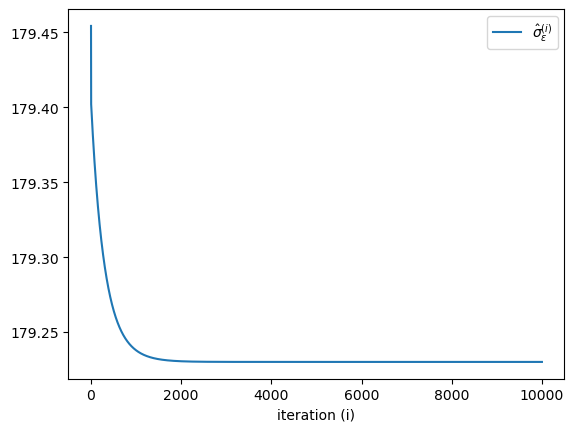

In [24]:
plt.plot(shs_eps, label=r"$\hat{\sigma}^{(i)}_\epsilon$")
plt.xlabel("iteration (i)"); plt.legend()

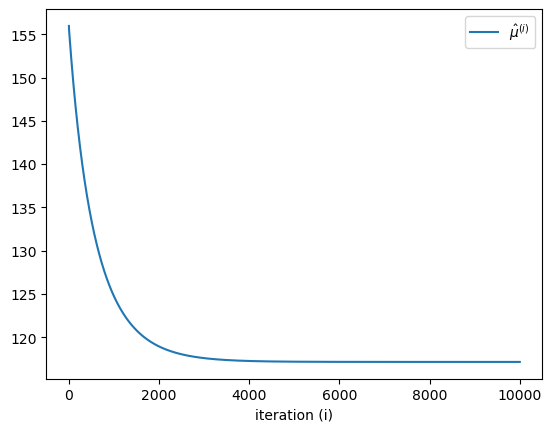

In [25]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

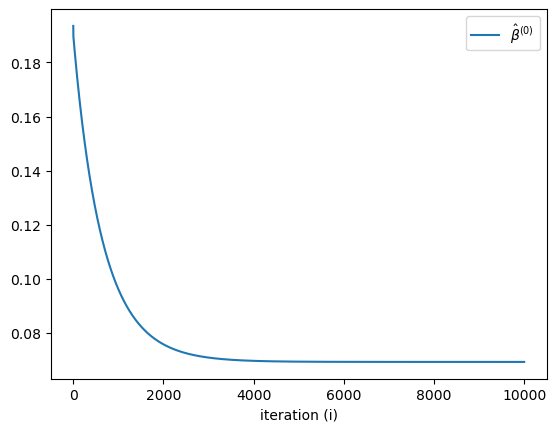

In [26]:
plt.plot(bhs[:,0], label=r"$\hat{\beta}^{(0)}$")
plt.xlabel("iteration (i)"); plt.legend()

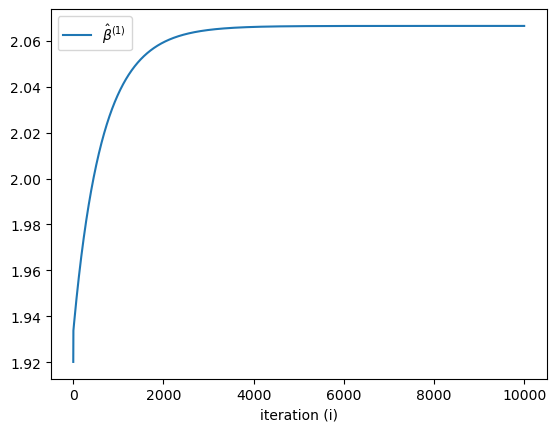

In [27]:
plt.plot(bhs[:,1], label=r"$\hat{\beta}^{(1)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. EDA for nonparametric bootstrap

In [28]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [29]:
for t in np.arange(T+T0):
    o = np.exp(bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = - K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

In [30]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [31]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [32]:
Pi_inv_ImG = Pi @ inv_ImG

In [33]:
EY = (Y_data @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2) * Pi_inv_ImG[:,0]

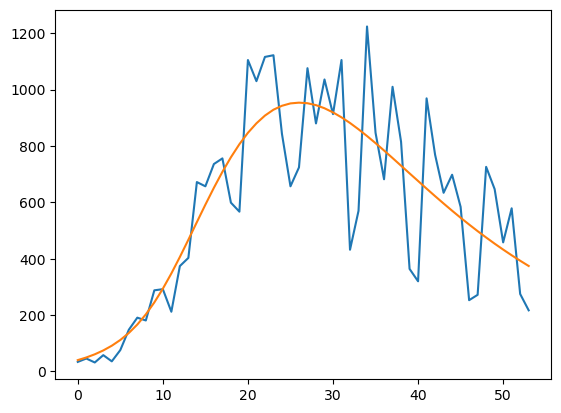

In [34]:
plt.plot(Y_data)
plt.plot(EY)

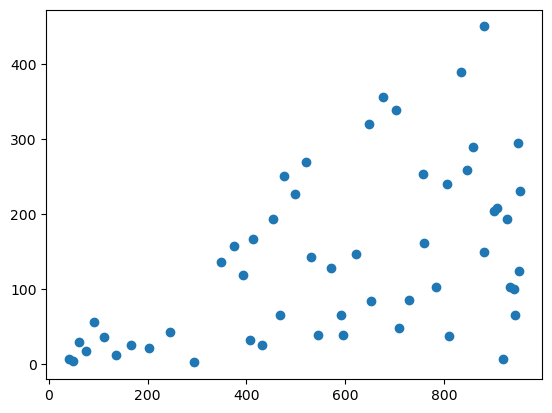

In [35]:
plt.scatter(EY, abs(Y_data-EY))

In [36]:
eps_data = (Y_data-EY)/np.sqrt(EY)

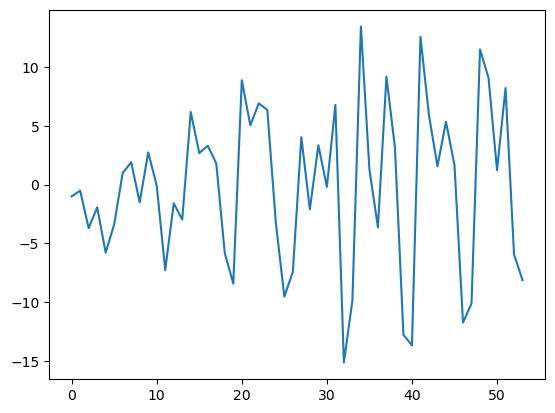

In [37]:
plt.plot(eps_data)

In [38]:
ar_order = 7
auto_eps = np.zeros(T)
for i in np.arange(ar_order+1):
    auto_eps[i] = np.mean(eps_data[i:] * eps_data[:T-i])

In [39]:
phi = la.solve(
    auto_eps[np.abs(np.arange(ar_order)[:,None] - np.arange(ar_order))],
    auto_eps[1:ar_order+1]
)

In [40]:
for i in np.arange(ar_order+1, T):
    auto_eps[i] = auto_eps[i-ar_order:i] @ phi[::-1]

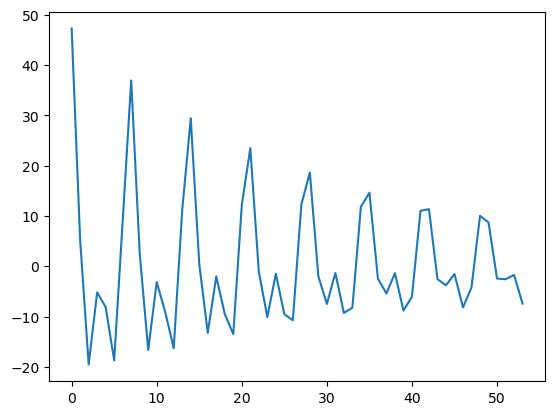

In [41]:
plt.plot(auto_eps)

In [42]:
Sigma_eps = auto_eps[np.abs(np.arange(T)[:,None] - np.arange(T))]

# 5. Nonparametric bootstrap

## simulation

In [48]:
n_iter = 10000

In [43]:
eps_sim = np.random.multivariate_normal(np.zeros(T), Sigma_eps)

In [44]:
Y_sim = EY + np.sqrt(EY)*eps_sim

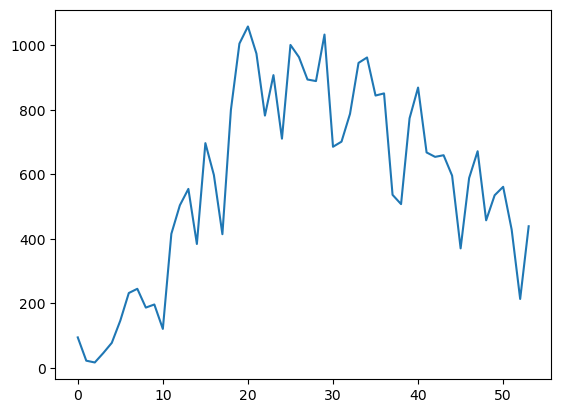

In [45]:
plt.plot(Y_sim)

In [49]:
mhat_0, shat_eps, bhat =\
    fit(Y_sim, minit_0 = mmle_0, sinit_eps = smle_eps,
        binit = bmle, history=True, n_iter=n_iter, step_size=0.05) 

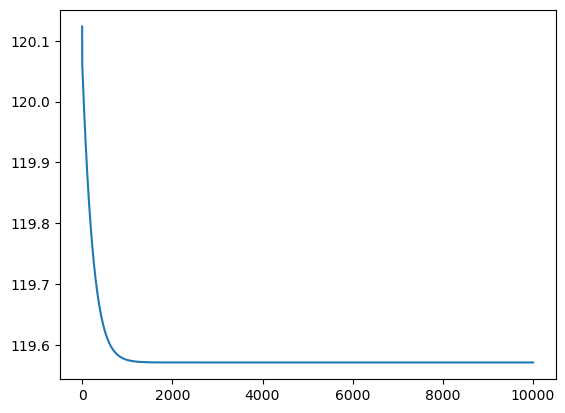

In [50]:
plt.plot(shat_eps)

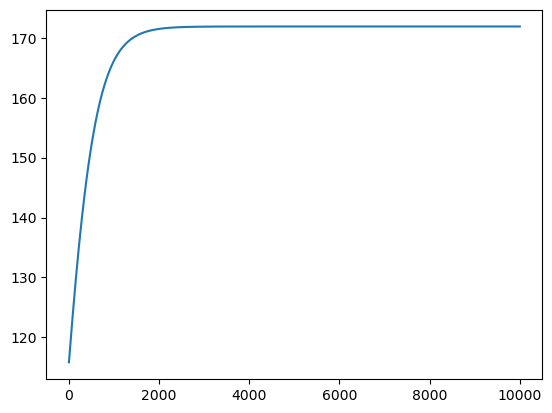

In [51]:
plt.plot(mhat_0)

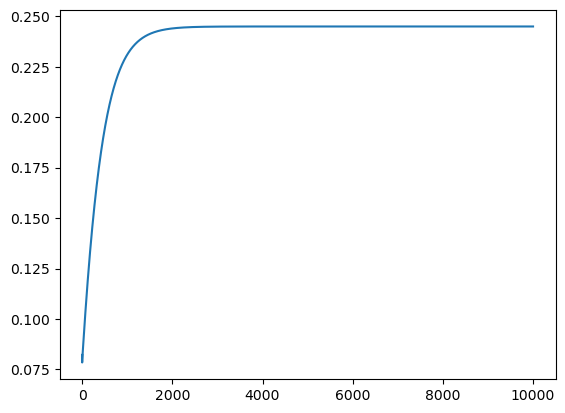

In [52]:
plt.plot(bhat[:,0])

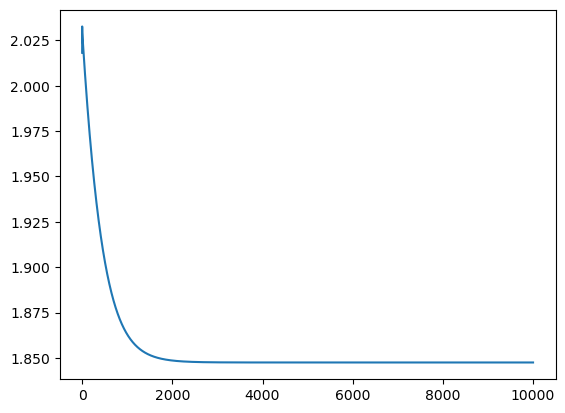

In [53]:
plt.plot(bhat[:,1])

## iteration

In [58]:
num_sim = 100

In [59]:
msim_0 = np.zeros([num_sim, n_iter])
ssim_eps = np.zeros([num_sim, n_iter])
bsim = np.zeros([num_sim, n_iter, d])

In [60]:
Ys_sim = np.zeros([num_sim, T])

In [61]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    eps_sim = np.random.multivariate_normal(np.zeros(T), Sigma_eps)
    Y_sim = EY + np.sqrt(EY) * eps_sim
    
    mhat_0, shat_eps, bhat =\
        fit(Y_sim, minit_0 = mmle_0, sinit_eps = smle_eps,
            binit = bmle, history=True, n_iter=n_iter, step_size=0.05) 
    
    msim_0[iter_sim] = mhat_0
    ssim_eps[iter_sim] = shat_eps
    bsim[iter_sim] = bhat
    
    Ys_sim[iter_sim] = Y_sim
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 14.910868 sec.
2-th simulation finished, 13.049293 sec.
3-th simulation finished, 13.836876 sec.
4-th simulation finished, 13.007005 sec.
5-th simulation finished, 12.810166 sec.
6-th simulation finished, 13.246529 sec.
7-th simulation finished, 14.196813 sec.
8-th simulation finished, 17.521251 sec.
9-th simulation finished, 15.967818 sec.
10-th simulation finished, 16.155193 sec.
11-th simulation finished, 14.896550 sec.
12-th simulation finished, 13.242756 sec.
13-th simulation finished, 13.185936 sec.
14-th simulation finished, 13.288175 sec.
15-th simulation finished, 13.822056 sec.
16-th simulation finished, 14.457114 sec.
17-th simulation finished, 17.402639 sec.
18-th simulation finished, 15.471407 sec.
19-th simulation finished, 18.013231 sec.
20-th simulation finished, 21.251222 sec.
21-th simulation finished, 18.392233 sec.
22-th simulation finished, 19.774223 sec.
23-th simulation finished, 16.898502 sec.
24-th simulation finished, 20.809797 sec.
2

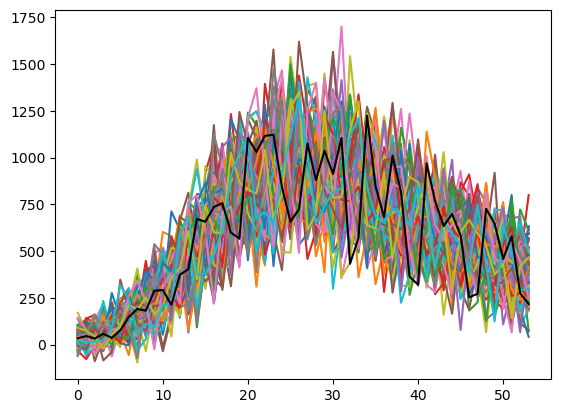

In [62]:
plt.plot(Ys_sim.T)
plt.plot(Y_data, color='black')
plt.show()

## plots

In [63]:
id_valid = (ssim_eps[:,0] - ssim_eps[:,-1] > 0)

(array([ 6., 18., 14., 12., 20., 14.,  7.,  2.,  3.,  4.]),
 array([100.28167272, 115.52427646, 130.76688021, 146.00948396,
        161.2520877 , 176.49469145, 191.73729519, 206.97989894,
        222.22250269, 237.46510643, 252.70771018]),
 <BarContainer object of 10 artists>)

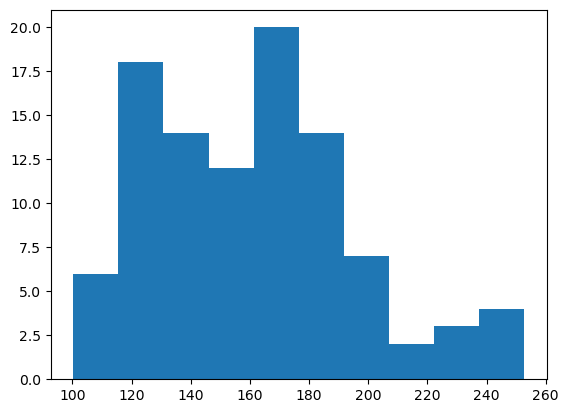

In [64]:
plt.hist(ssim_eps[id_valid,-1])

(array([11., 13., 20., 15., 15.,  5.,  9.,  4.,  6.,  2.]),
 array([ 59.69955717,  75.30183793,  90.90411869, 106.50639945,
        122.10868021, 137.71096097, 153.31324173, 168.91552249,
        184.51780325, 200.12008401, 215.72236477]),
 <BarContainer object of 10 artists>)

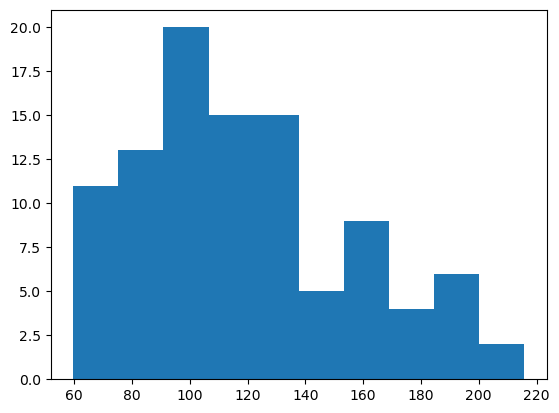

In [65]:
plt.hist(msim_0[id_valid,-1])

Text(0, 0.5, '$\\hat{\\beta}_1$')

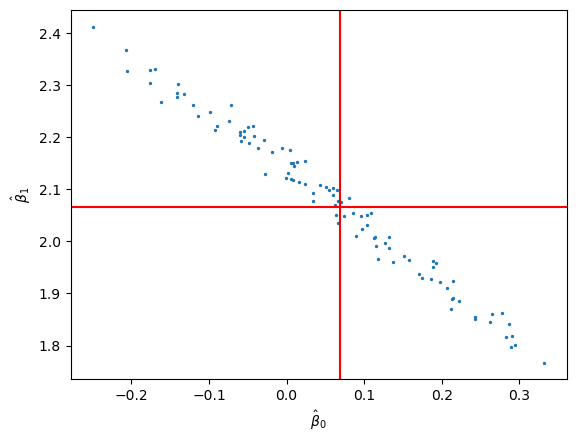

In [66]:
plt.scatter(bsim[id_valid,-1,0],bsim[id_valid,-1,1], s=2)
plt.axhline(y=bmle[1], color='red')
plt.axvline(x=bmle[0], color='red')
plt.xlabel(r"$\hat{\beta}_0$"); plt.ylabel(r"$\hat{\beta}_1$")

In [67]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[0,0])

0.13502315510848814

In [68]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[1,1])

0.14940743644727944

In [69]:
np.cov(bsim[id_valid,-1,:].T)

array([[ 0.01823125, -0.0199795 ],
       [-0.0199795 ,  0.02232258]])

In [70]:
Rsim = np.zeros([T+T0,np.sum(id_valid)])
for t in np.arange(T+T0):
    Rsim[t] = K / (1 + np.exp(bsim[id_valid,-1,:] @ A[t]))

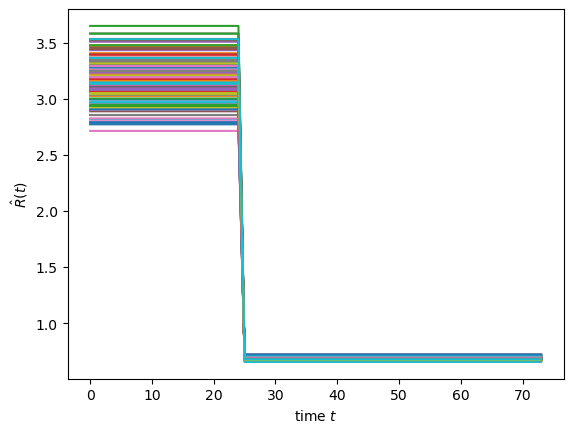

In [71]:
plt.plot(Rsim)
plt.xlabel(r"time $t$"); plt.ylabel(r"$\hat{R}(t)$")
plt.show()

# save and load

In [153]:
# np.savez("result_nonparametric_zero_s_eta.npz",
#          mmle_0 = mmle_0, smle_eps = smle_eps, bmle = bmle,
#          mhs_0 = mhs_0, shs_eps = shs_eps, bhs = bhs,
#          msim_0 = msim_0, ssim_eps = ssim_eps, bsim = bsim,
#          Ys_sim = Ys_sim)

In [20]:
locals().update(np.load("result_nonparametric_zero_s_eta.npz"))